# **Import Dependencies**

In [1]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

# **Data Paths /  Weights / Hparams**

In [32]:
file_name = 'tweets.csv'
headers = ['target', 'ids', 'date', 'flag', 'user', 'text']

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stopwords_list = stopwords.words('english')

random_state = 1234
test_size = 0.15
val_size = 0.15

oov_token = '<OOV>'
pad_token = '<PAD>'
device =  torch.device('cpu' if not torch.cuda.is_available() else 'cuda:0') 
batch_size = 128

print("Device : {}".format(device))

Device : cuda:0


# **Load Intital Data Set, Analyze, Preprocess & VIsualize**

In [3]:
def get_data(file_namet, down_sample=True):
    data = pd.read_csv(
                    file_name,
                    names=headers,
                    encoding='latin-1'
                    )
    
    data = shuffle(data)
    
    data = data[['target', 'text']]
    data['target'] = data['target'].astype(int)
    data = data.dropna()
    
    if down_sample:
        data = data.sample(
                        frac=0.1, 
                        replace=False, 
                        random_state=random_state
                        ) # Since I have Limited Resources I downsample the dataset heavily
    return data

In [4]:
def vis_class_imbalance(data):
    target = data['target'].values
    counts = pd.Series(target).value_counts()
    sns.barplot(
            x=np.array(['negative','positive']),
            y=counts.values
               )  
    plt.title('Class Imbalance of Twitter Dataset')
    plt.xlabel('Sentiment')
    plt.xlabel('Counts')
    plt.savefig('imbalance.png')
    plt.show()

In [5]:
def lemmatization(lemmatizer,sentence):
    lem = [lemmatizer.lemmatize(k) for k in sentence]
    return [k for k in lem if k]

def remove_stop_words(stopwords_list,sentence):
    return [k for k in sentence if k not in stopwords_list]

def preprocess_one(tweet):
    tweet = tweet.lower()
    remove_punc = tokenizer.tokenize(tweet) # Remove puntuations
    remove_num = [re.sub('[0-9]', '', i) for i in remove_punc] # Remove Numbers
    remove_num = [i for i in remove_num if len(i)>0] # Remove empty strings
    lemmatized = lemmatization(lemmatizer,remove_num) # Word Lemmatization
    remove_stop = remove_stop_words(stopwords_list,lemmatized) # remove stop words
    updated_tweet = ' '.join(remove_stop)
    return updated_tweet

def preprocessed_data(tweets):
    updated_tweets = []
    if isinstance(tweets, np.ndarray) or isinstance(tweets, list):
        for tweet in tweets:
            updated_tweet = preprocess_one(tweet)
            updated_tweets.append(updated_tweet)
    elif isinstance(tweets, np.str_)  or isinstance(tweets, str):
        updated_tweets = [preprocess_one(tweets)]

    return np.array(updated_tweets)

In [6]:
data = get_data(file_name)

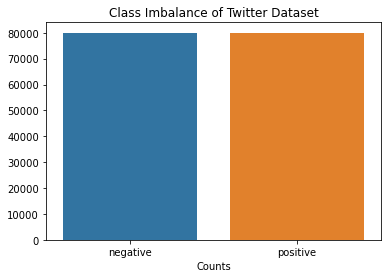

In [7]:
vis_class_imbalance(data)

In [8]:
tweets = data['text'].values
targets = data['target'].values

tweets, targets = shuffle(tweets, targets)

tweets = preprocessed_data(tweets)

X, X_test, Y, Y_test = train_test_split(
                                    tweets, 
                                    targets, 
                                    test_size=test_size, 
                                    random_state=random_state
                                    )

X, X_val, Y, Y_val = train_test_split(
                                    X, 
                                    Y, 
                                    test_size=val_size, 
                                    random_state=random_state
                                    )

print('Train Samples : {}'.format(len(Y)))
print('Val   Samples : {}'.format(len(Y_val)))
print('Test  Samples : {}'.format(len(Y_test)))

encoder = LabelEncoder()
encoder.fit(Y)

Y = encoder.transform(Y)
Y_val = encoder.transform(Y_val)
Y_test = encoder.transform(Y_test)

Train Samples : 115600
Val   Samples : 20400
Test  Samples : 24000


# **Create Vocabulary, Tokenization & Padding**

In [9]:
def extract_vocabulary(X):
    vocab = {}
    for x in X:
        tokens = x.split(' ')
        for token in tokens:
            if token in vocab:
                vocab[token] += 1
            else:
                vocab[token] = 1
                
    vocab  = dict(
                sorted(
                    vocab.items(), 
                    key=lambda item: item[1], 
                    reverse=True
                       )
                )
    vocab = {token : idx+1 for idx, token in enumerate(list(vocab.keys()))}
    
    vocab[oov_token] = len(vocab) + 1
    vocab[pad_token] = 0
    
    print(f'The Size of the Vocabulary is {len(vocab)}')
    
    return vocab

def tokenize_data(tweets, vocab):
    sequences = []
    for tweet in tweets:
        tokens = tweet.split(' ')
        sequence = [vocab[token] if (token in vocab) else vocab[oov_token] for token in tokens]
        sequences.append(sequence)
    return sequences

def vis_length_variation(X_SEQ):
    X_len = [len(i) for i in X_SEQ]
    X_len = pd.Series(X_len)
    X_len.hist()
    plt.xlabel('Token Length')
    plt.ylabel('Samples')
    plt.savefig('sequence length.png')
    plt.show()
    
    print(X_len.describe())

In [10]:
vocab = extract_vocabulary(X)

The Size of the Vocabulary is 98735


In [11]:
X_SEQ = tokenize_data(X, vocab)
X_val_SEQ = tokenize_data(X_val, vocab)
X_test_SEQ = tokenize_data(X_test, vocab)

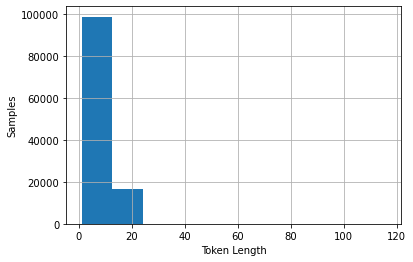

count    115600.000000
mean          7.791462
std           4.106026
min           1.000000
25%           5.000000
50%           7.000000
75%          11.000000
max         116.000000
dtype: float64


In [12]:
vis_length_variation(X_SEQ)

In [48]:
max_length = 116

In [49]:
def pad_tokens(sequences, max_length=max_length):
    seq_tensor = np.zeros((len(sequences), max_length))
    for idx, sequence in enumerate(sequences):
        if len(sequence) >= max_length:
            seq_tensor[idx, :] = np.array(sequence[:max_length])
        else:
            redundancy_length = max_length - len(sequence)
            padded_sequence = [vocab[pad_token]] * redundancy_length + sequence
            seq_tensor[idx, :] = np.array(padded_sequence)
            
    return seq_tensor

In [50]:
X_PAD = pad_tokens(X_SEQ)
X_val_PAD = pad_tokens(X_val_SEQ)
X_test_PAD = pad_tokens(X_test_SEQ)

In [51]:
X_PAD = X_PAD.astype(np.int32)
X_val_PAD = X_val_PAD.astype(np.int32)
X_test_PAD = X_test_PAD.astype(np.int32)

In [52]:
X_PAD

array([[    0,     0,     0, ...,   280,     1,  1790],
       [    0,     0,     0, ...,     0, 17383,   301],
       [    0,     0,     0, ...,   510,    58,   190],
       ...,
       [    0,     0,     0, ...,   198,    20,    70],
       [    0,     0,     0, ...,   896,  3014, 27633],
       [    0,     0,     0, ...,  5814,  2134,    16]])

In [53]:
X_val_PAD

array([[    0,     0,     0, ...,  5526,   558,   113],
       [    0,     0,     0, ...,     0,    36,  1359],
       [    0,     0,     0, ...,   216,  6294,    56],
       ...,
       [    0,     0,     0, ...,  2568,   100,   363],
       [    0,     0,     0, ...,    51,   335,   458],
       [    0,     0,     0, ..., 98734,   284,    55]])

In [54]:
X_test_PAD

array([[    0,     0,     0, ...,  5489,    12,   219],
       [    0,     0,     0, ...,  3128,  1864,   431],
       [    0,     0,     0, ...,  1012,     6,    31],
       ...,
       [    0,     0,     0, ...,   925,  9516,   220],
       [    0,     0,     0, ...,  8053,   349,    48],
       [    0,     0,     0, ..., 98734,   709,    16]])

# **Numpy to Troch DataLoader**

In [55]:
#Tensor Dataset
train_data = TensorDataset(
                    torch.from_numpy(X_PAD), 
                    torch.from_numpy(Y)
                            )

valid_data = TensorDataset(
                    torch.from_numpy(X_val_PAD), 
                    torch.from_numpy(Y_val)
                            )

test_data = TensorDataset(
                    torch.from_numpy(X_test_PAD), 
                    torch.from_numpy(Y_test)
                            )

# dataloaders
train_loader = DataLoader(
                    train_data, 
                    shuffle=True, 
                    drop_last=True,
                    batch_size=batch_size
                        )

valid_loader = DataLoader(
                    valid_data, 
                    shuffle=True, 
                    drop_last=True,
                    batch_size=batch_size
                        )

test_data = DataLoader(
                    test_data, 
                    shuffle=True,
                    drop_last=True,
                    batch_size=batch_size
                        )

In [56]:
# Check the Data Shapes of DataLoader Iteration
x_next, y_next = iter(train_loader).next()

print('Input  Sample : \n{}'.format(x_next.to(device)))
print('Output Sample : \n{}'.format(y_next.to(device)))

Input  Sample : 
tensor([[    0,     0,     0,  ...,     0,    77,    75],
        [    0,     0,     0,  ...,    43,   317,   558],
        [    0,     0,     0,  ...,    29,   118,   694],
        ...,
        [    0,     0,     0,  ...,  1573,  1217,   614],
        [    0,     0,     0,  ...,   510,   100, 97212],
        [    0,     0,     0,  ...,    15,   441,   211]], device='cuda:0',
       dtype=torch.int32)
Output Sample : 
tensor([0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')


# **Sentiment Analysis LSTM Model**

In [57]:
class SentimentAnalysis(nn.Module):
    def __init__(
                self, 
                vocab_size, 
                num_layers=2,
                embedding_dim=256,
                hidden_dim_lstm=256,
                hidden_dim_linear1=512,
                hidden_dim_linear2=256,
                hidden_dim_linear3=64,
                dropout_rate = 0.4,
                device=device
                ):
        super(SentimentAnalysis,self).__init__()
        
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(
                                input_size=embedding_dim,
                                hidden_size=hidden_dim_lstm,
                                num_layers=num_layers, 
                                batch_first=True
                                )
        
        self.dropout_layer = nn.Dropout(dropout_rate)

        self.linear_layer0 = nn.Linear(hidden_dim_lstm, hidden_dim_linear1)
        self.linear_layer1 = nn.Linear(hidden_dim_linear1, hidden_dim_linear2)
        self.linear_layer2 = nn.Linear(hidden_dim_linear2, hidden_dim_linear3)
        self.linear_layer3 = nn.Linear(hidden_dim_linear3, 1)
        
        self.output_layer = nn.Sigmoid()
        
        
        self.device = device
        self.num_layers = num_layers
        self.hidden_dim_lstm = hidden_dim_lstm
        
    def forward(self, x):
        x = x.long()
        h_init = torch.zeros(self.num_layers, batch_size, self.hidden_dim_lstm).to(self.device)
        c_init = torch.zeros(self.num_layers, batch_size, self.hidden_dim_lstm).to(self.device)
        
        memory_init = (h_init, c_init)
        
        x = self.embedding_layer(x)
        x, _ = self.lstm_layer(x, memory_init) 
        
        '''
        
        output shape : (batch_size, sequence_length, hidden_dim)
        
        But we only need the output of last time step (end of the sequence). so the 
        required output shape is,
                       (batch_size, 1, hidden_dim)
                       
        After Squeezing over 2nd dimension output should be,
                       (batch_size, hidden_dim) 
        
        '''
        
        x = x[:,-1,:]
        x = x.view(batch_size, self.hidden_dim_lstm)
        
        x = self.dropout_layer(x)
        x = self.linear_layer0(x)
        x = self.linear_layer1(x)
        x = self.linear_layer2(x)
        x = self.linear_layer3(x)
        
        x = self.output_layer(x)
        return x


# **Model Loss / Optimizer & Metrics**

In [58]:
vocab_size = len(vocab) + 1
model = SentimentAnalysis(vocab_size)
model = model.to(device)

In [59]:
learning_rate = 0.0001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
                        model.parameters(), 
                        lr = learning_rate
                        )

In [60]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# **Model Training**

In [61]:
def train_epoch():
    
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    val_epoch_loss = 0
    val_epoch_acc = 0

    model.train() # Training the Model
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) 
        
        optimizer.zero_grad()
        predictions = model(inputs).squeeze(1)
        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels.float())
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()
        
    train_epoch_loss = train_epoch_loss / len(train_loader)
    train_epoch_acc = train_epoch_acc / len(train_loader)
    
    model.eval() # Validate the Model
        
    for inputs, labels in tqdm(valid_loader):
        inputs, labels = inputs.to(device), labels.to(device) 
        
        predictions = model(inputs).squeeze()

        loss = criterion(predictions, labels.float())
        acc = binary_accuracy(predictions, labels.float())
        
        val_epoch_loss += loss.item()
        val_epoch_acc += acc.item()
        
    val_epoch_loss = val_epoch_loss / len(valid_loader)
    val_epoch_acc = val_epoch_acc / len(valid_loader)
    
    return train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc

In [62]:
epochs = 30

train_loss = []
train_acc = []

val_loss = []
val_acc = []

for epoch in range(1, epochs+1):
    print('Epoch {}\n'.format(epoch))
    train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc = train_epoch()
    
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)
    
    print('Train Loss : {}, Validation Loss : {}'.format(
                                                    round(train_epoch_loss, 3), 
                                                    round(val_epoch_loss, 3)
                                                         ))
    print('Train Acc  : {}, Validation Acc  : {}'.format(
                                                    round(train_epoch_acc, 3),  
                                                    round(val_epoch_acc, 3)
                                                        ))

  0%|                                                                                          | 0/903 [00:00<?, ?it/s]

Epoch 1



  1%|▌                                                                                 | 6/903 [00:00<00:30, 29.09it/s]

Train Loss : 0.594, Validation Loss : 0.547
Train Acc  : 0.672, Validation Acc  : 0.714
Epoch 2



  0%|▎                                                                                 | 3/903 [00:00<00:32, 27.77it/s]

Train Loss : 0.518, Validation Loss : 0.524
Train Acc  : 0.742, Validation Acc  : 0.736
Epoch 3



  0%|▎                                                                                 | 3/903 [00:00<00:32, 28.03it/s]

Train Loss : 0.483, Validation Loss : 0.515
Train Acc  : 0.768, Validation Acc  : 0.747
Epoch 4



  0%|▎                                                                                 | 3/903 [00:00<00:33, 27.27it/s]

Train Loss : 0.452, Validation Loss : 0.514
Train Acc  : 0.788, Validation Acc  : 0.75
Epoch 5



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.84it/s]

Train Loss : 0.421, Validation Loss : 0.509
Train Acc  : 0.807, Validation Acc  : 0.753
Epoch 6



  0%|▎                                                                                 | 3/903 [00:00<00:40, 22.06it/s]

Train Loss : 0.39, Validation Loss : 0.545
Train Acc  : 0.825, Validation Acc  : 0.751
Epoch 7



  0%|▎                                                                                 | 3/903 [00:00<00:32, 27.75it/s]

Train Loss : 0.355, Validation Loss : 0.564
Train Acc  : 0.845, Validation Acc  : 0.749
Epoch 8



  0%|▎                                                                                 | 3/903 [00:00<00:39, 23.07it/s]

Train Loss : 0.318, Validation Loss : 0.622
Train Acc  : 0.863, Validation Acc  : 0.742
Epoch 9



  0%|▎                                                                                 | 3/903 [00:00<00:30, 29.41it/s]

Train Loss : 0.281, Validation Loss : 0.66
Train Acc  : 0.882, Validation Acc  : 0.74
Epoch 10



  0%|▎                                                                                 | 3/903 [00:00<00:34, 25.86it/s]

Train Loss : 0.244, Validation Loss : 0.752
Train Acc  : 0.9, Validation Acc  : 0.731
Epoch 11



  0%|▎                                                                                 | 3/903 [00:00<00:30, 29.40it/s]

Train Loss : 0.207, Validation Loss : 0.832
Train Acc  : 0.917, Validation Acc  : 0.727
Epoch 12



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.84it/s]

Train Loss : 0.174, Validation Loss : 1.049
Train Acc  : 0.931, Validation Acc  : 0.726
Epoch 13



  0%|▎                                                                                 | 3/903 [00:00<00:30, 29.12it/s]

Train Loss : 0.142, Validation Loss : 1.09
Train Acc  : 0.946, Validation Acc  : 0.728
Epoch 14



  0%|▎                                                                                 | 3/903 [00:00<00:37, 23.80it/s]

Train Loss : 0.119, Validation Loss : 1.337
Train Acc  : 0.955, Validation Acc  : 0.724
Epoch 15



  0%|▎                                                                                 | 3/903 [00:00<00:30, 29.12it/s]

Train Loss : 0.097, Validation Loss : 1.653
Train Acc  : 0.964, Validation Acc  : 0.721
Epoch 16



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.84it/s]

Train Loss : 0.08, Validation Loss : 2.092
Train Acc  : 0.971, Validation Acc  : 0.721
Epoch 17



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.57it/s]

Train Loss : 0.067, Validation Loss : 2.244
Train Acc  : 0.976, Validation Acc  : 0.705
Epoch 18



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.57it/s]

Train Loss : 0.059, Validation Loss : 2.578
Train Acc  : 0.978, Validation Acc  : 0.717
Epoch 19



  0%|▎                                                                                 | 3/903 [00:00<00:33, 27.02it/s]

Train Loss : 0.053, Validation Loss : 3.189
Train Acc  : 0.981, Validation Acc  : 0.714
Epoch 20



  1%|▌                                                                                 | 6/903 [00:00<00:31, 28.40it/s]

Train Loss : 0.046, Validation Loss : 2.93
Train Acc  : 0.983, Validation Acc  : 0.716
Epoch 21



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.84it/s]

Train Loss : 0.042, Validation Loss : 3.097
Train Acc  : 0.985, Validation Acc  : 0.718
Epoch 22



  0%|▎                                                                                 | 3/903 [00:00<00:36, 24.79it/s]

Train Loss : 0.037, Validation Loss : 3.252
Train Acc  : 0.987, Validation Acc  : 0.716
Epoch 23



  0%|▎                                                                                 | 3/903 [00:00<00:33, 26.78it/s]

Train Loss : 0.04, Validation Loss : 3.761
Train Acc  : 0.987, Validation Acc  : 0.715
Epoch 24



  0%|▎                                                                                 | 3/903 [00:00<00:30, 29.41it/s]

Train Loss : 0.033, Validation Loss : 4.17
Train Acc  : 0.989, Validation Acc  : 0.721
Epoch 25



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.84it/s]

Train Loss : 0.032, Validation Loss : 3.926
Train Acc  : 0.989, Validation Acc  : 0.716
Epoch 26



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.56it/s]

Train Loss : 0.028, Validation Loss : 3.442
Train Acc  : 0.99, Validation Acc  : 0.717
Epoch 27



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.56it/s]

Train Loss : 0.027, Validation Loss : 4.112
Train Acc  : 0.991, Validation Acc  : 0.721
Epoch 28



  1%|▌                                                                                 | 6/903 [00:00<00:31, 28.90it/s]

Train Loss : 0.025, Validation Loss : 3.468
Train Acc  : 0.991, Validation Acc  : 0.709
Epoch 29



  0%|▎                                                                                 | 3/903 [00:00<00:31, 28.57it/s]

Train Loss : 0.024, Validation Loss : 4.55
Train Acc  : 0.991, Validation Acc  : 0.72
Epoch 30



100%|███████████████████████████████████████████████████████████████████████████████| 159/159 [00:01<00:00, 124.78it/s]

Train Loss : 0.022, Validation Loss : 3.182
Train Acc  : 0.993, Validation Acc  : 0.717


# **Visualize the Performance Metrics**

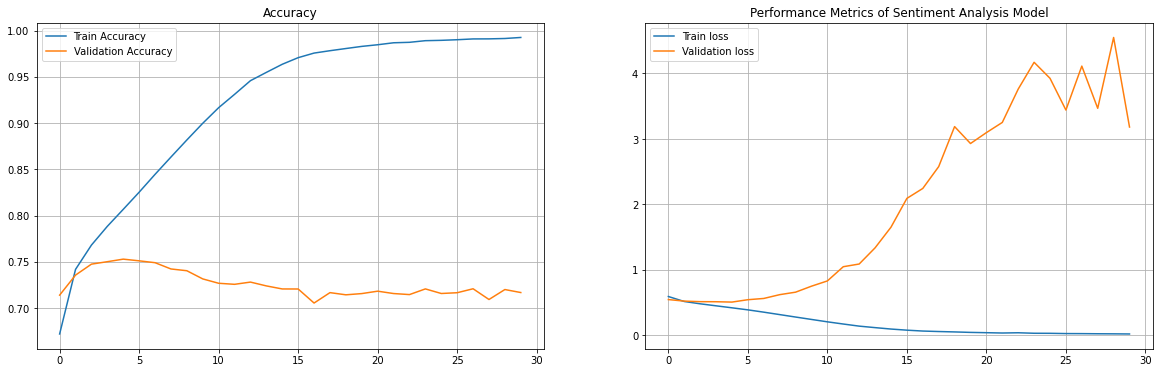

In [63]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.title('Performance Metrics of Sentiment Analysis Model')
plt.savefig('performance.png')
plt.show()